In [1]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/amiangshu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/amiangshu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: Fut

In [2]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('../crawl-300d-2M.vec', encoding='utf-8')
'''
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))
'''

loading word embeddings...


"\nfor line in tqdm(f):\n    values = line.rstrip().rsplit(' ')\n    word = values[0]\n    coefs = np.asarray(values[1:], dtype='float32')\n    embeddings_index[word] = coefs\nf.close()\n\nprint('found %s word vectors' % len(embeddings_index))\n"

In [3]:
from sklearn.model_selection import train_test_split
#load data
data = pd.read_csv('code-review-dataset-full.csv', sep=',', header=0)

#data  =pd.read_excel('../code-review-dataset-full.xlsx')
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
test_data.to_csv("SEtest_dat.csv")
train_data.to_csv("SEtrain_dat.csv")

train_df = pd.read_csv('SEtrain_dat.csv', sep=',', header=0)
test_df = pd.read_csv('SEtest_dat.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  15656
Number of testing data:  3915


/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


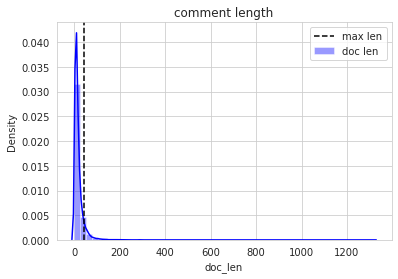

In [4]:
label_names = ["is_toxic"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['message'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [5]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['message'].tolist()
raw_docs_test = test_df['message'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  4%|▍         | 623/15656 [00:00<00:02, 6217.75it/s]

pre-processing train data...


100%|██████████| 3915/3915 [00:00<00:00, 6537.64it/s]


tokenizing input data...
dictionary size:  16808


In [6]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [7]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 16809


In [8]:
print("sample words not found: ", np.random.choice(words_not_found, 10))


sample words not found:  ['quickly' 'libcutils' 'vanilla' 'mentrystack' "'vip" 'addentry'
 '857adeada9cc3276e79ceb828959a3ffe2d7409b' 'secondaries' 'valueof'
 'kbits']


In [9]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 300)           5042700   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
____________________________________________________________

In [10]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10959 samples, validate on 4697 samples
Epoch 1/40
10959/10959 [==============================] - 4s 354us/sample - loss: 0.6868 - acc: 0.8077 - val_loss: 0.6800 - val_acc: 0.8120
Epoch 2/40
10959/10959 [==============================] - 3s 300us/sample - loss: 0.6741 - acc: 0.8077 - val_loss: 0.6675 - val_acc: 0.8120
Epoch 3/40
10959/10959 [==============================] - 3s 279us/sample - loss: 0.6622 - acc: 0.8077 - val_loss: 0.6557 - val_acc: 0.8120
Epoch 4/40
10959/10959 [==============================] - 3s 279us/sample - loss: 0.6508 - acc: 0.8077 - val_loss: 0.6445 - val_acc: 0.8120
Epoch 5/40
10959/10959 [==============================] - 3s 278us/sample - loss: 0.6401 - acc: 0.8077 - val_loss: 0.6340 - val_acc: 0.8120
Epoch 6/40
10959/10959 [==============================] - 3s 276us/sample - loss: 0.6300 - acc: 0.8077 - val_loss: 0.6240 - val_acc: 0.8120
Epoch 7/40
10959/

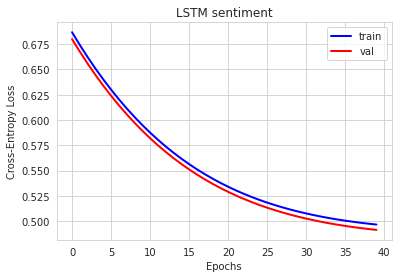

In [11]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

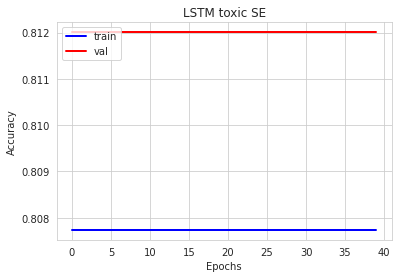

In [12]:
plt.figure()
plt.plot(history.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('LSTM toxic SE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [13]:
keras.backend.clear_session()

In [14]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('../glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))


1268it [00:00, 12674.84it/s]

loading word embeddings...


2196018it [02:25, 15129.12it/s]

found 2196016 word vectors


In [15]:

from sklearn.utils import shuffle 

raw_docs_train = train_df['message'].tolist()
raw_docs_test = test_df['message'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  4%|▍         | 653/15656 [00:00<00:02, 6526.51it/s]

pre-processing train data...


100%|██████████| 3915/3915 [00:00<00:00, 6705.52it/s]


tokenizing input data...
dictionary size:  16808


In [16]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_glove = tf.keras.Sequential()

model_glove.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model_glove.add(Bidirectional(LSTM(32)))
model_glove.add(Dense(32,activation='relu'))
model_glove.add(Dropout(0.4))
model_glove.add(Dense(1,activation='sigmoid'))
model_glove.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 300)           5042700   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,130,061
Trainable params: 87,361
Non-trainable params: 5,042,700
_________________________________________________________________


In [17]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = model_glove.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Train on 10959 samples, validate on 4697 samples
Epoch 1/40
10959/10959 [==============================] - 4s 391us/sample - loss: 0.6868 - acc: 0.8077 - val_loss: 0.6800 - val_acc: 0.8120
Epoch 2/40
10959/10959 [==============================] - 3s 276us/sample - loss: 0.6741 - acc: 0.8077 - val_loss: 0.6675 - val_acc: 0.8120
Epoch 3/40
10959/10959 [==============================] - 3s 280us/sample - loss: 0.6622 - acc: 0.8077 - val_loss: 0.6557 - val_acc: 0.8120
Epoch 4/40
10959/10959 [==============================] - 3s 278us/sample - loss: 0.6508 - acc: 0.8077 - val_loss: 0.6445 - val_acc: 0.8120
Epoch 5/40
10959/10959 [==============================] - 3s 279us/sample - loss: 0.6401 - acc: 0.8077 - val_loss: 0.6340 - val_acc: 0.8120
Epoch 6/40
10959/10959 [==============================] - 3s 295us/sample - loss: 0.6300 - acc: 0.8077 - val_loss: 0.6240 - val_acc: 0.8120
Epoch 7/40
10959/10959 [==============================] - 3s 281us/sample - loss: 0.6205 - acc: 0.8077 - val_lo

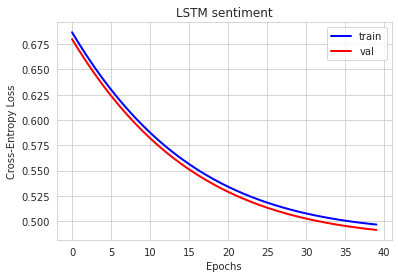

In [19]:
#generate plots
plt.figure()
plt.plot(history_glove.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

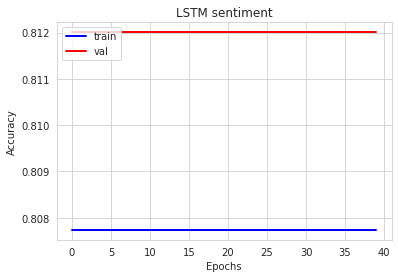

In [20]:
plt.figure()
plt.plot(history_glove.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [21]:
predictions = model_glove.predict_classes(word_seq_test)
sample=pd.read_csv('SEtest_dat.csv')
sample['pred']= (predictions>=0.5).astype(int)

In [22]:
print(sample)

      Unnamed: 0                                            message  is_toxic  \
0           6134  Yeah, I think this comment doesn't add anythin...         0   
1           5631  use std::string and StringPrintf() from base/s...         0   
2          16782                     Wrong param. Should be cg_ref.         0   
3           7125                                        double crap         1   
4           4871  These log tags are going to be kind of shit. W...         1   
...          ...                                                ...       ...   
3910       18184                    public_endpoint, admin_endpoint         0   
3911        5245  This naming sucks.  Better\n\n for test_specs ...         1   
3912       14490  Yuck and a half. I need to start a petition to...         1   
3913       10665                  These should be run through i18n.         0   
3914        5348  This string seems a bit awkward, have we run i...         0   

      pred  
0        0  
1

In [23]:

import sklearn
print("Accuracy With GloVe :")
print(sklearn.metrics.accuracy_score(sample.is_toxic, sample.pred))
from sklearn import metrics
print(metrics.classification_report(sample.is_toxic, sample.pred))

Accuracy With GloVe :
0.8053639846743295
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      3153
           1       0.00      0.00      0.00       762

    accuracy                           0.81      3915
   macro avg       0.40      0.50      0.45      3915
weighted avg       0.65      0.81      0.72      3915



/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
keras.backend.clear_session()

In [25]:
from keras.layers import BatchNormalization
import tensorflow as tf

without_mod = tf.keras.Sequential()

without_mod.add(Embedding(nb_words,embed_dim,input_length=max_seq_len,trainable=False))
without_mod.add(Bidirectional(LSTM(32)))
without_mod.add(Dense(32,activation='relu'))
without_mod.add(Dropout(0.4))
without_mod.add(Dense(1,activation='sigmoid'))
without_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 300)           5042700   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,130,061
Trainable params: 87,361
Non-trainable params: 5,042,700
_________________________________________________________________


In [26]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

without_mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = without_mod.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Train on 10959 samples, validate on 4697 samples
Epoch 1/40
10959/10959 [==============================] - 4s 384us/sample - loss: 0.5329 - acc: 0.8032 - val_loss: 0.4827 - val_acc: 0.8120
Epoch 2/40
10959/10959 [==============================] - 3s 275us/sample - loss: 0.4943 - acc: 0.8077 - val_loss: 0.4785 - val_acc: 0.8120
Epoch 3/40
10959/10959 [==============================] - 3s 278us/sample - loss: 0.4837 - acc: 0.8077 - val_loss: 0.4656 - val_acc: 0.8120
Epoch 4/40
10959/10959 [==============================] - 3s 278us/sample - loss: 0.4634 - acc: 0.8084 - val_loss: 0.4412 - val_acc: 0.8086
Epoch 5/40
10959/10959 [==============================] - 3s 278us/sample - loss: 0.4350 - acc: 0.8090 - val_loss: 0.4175 - val_acc: 0.8095
Epoch 6/40
10959/10959 [==============================] - 3s 281us/sample - loss: 0.4140 - acc: 0.8144 - val_loss: 0.4037 - val_acc: 0.8178
Epoch 7/40
10959/10959 [==============================] - 3s 280us/sample - loss: 0.3983 - acc: 0.8283 - val_lo

In [34]:

predictions = without_mod.predict_classes(word_seq_test)
sample=pd.read_csv('SEtest_dat.csv')
sample['predictions']= (predictions>0.5).astype(int)

In [37]:
import sklearn
print("Accuracy Without GloVe :")
print(sklearn.metrics.accuracy_score(sample.is_toxic, sample.predictions))

Accuracy With GloVe :
0.8822477650063857


In [40]:
from sklearn import metrics
print(metrics.classification_report(sample.is_toxic, sample.predictions))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3153
           1       0.83      0.50      0.62       762

    accuracy                           0.88      3915
   macro avg       0.86      0.74      0.78      3915
weighted avg       0.88      0.88      0.87      3915



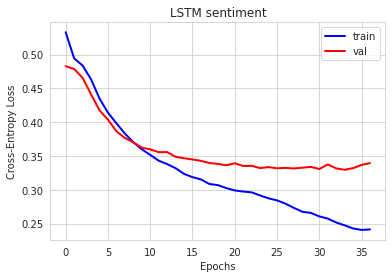

In [42]:
#generate plots
plt.figure()
plt.plot(history_glove.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()